# Lesson 5 - An integer to Binary-Coded decimal (BCD) Converter #

BCD stands for Binary-Coded Decimal. BCD was used in early computers to follow human practice.

We build a BCD converter that translates an integer number into its BCD representation

In [11]:
import sys
import platform
if (platform.uname().node == 'TPY14'):
    print('Dev machine')
    sys.path.append('..\\..\\..\\py4hw')

Dev machine


In [12]:
import math
import numpy as np
import py4hw

### Converting an Int value to a number of BCD digits  ###
To convert any intenger value to a 2 digit BCD we have to divide by 10 to get the highest digit and take the reminder of the division to get the lower digit. 

$BCD_1 = n / 10$

$BCD_0 = n \mod 10$

We can repeat the same idea to get any number of digits.


In [27]:
class IntToBCD(py4hw.Logic):
    def __init__(self, parent, name, a, r):
        super().__init__(parent, name)
        
        self.addIn('a',a)
        self.addOut('r', r)
        
        hlp = py4hw.LogicHelper(self)
        
        w = a.getWidth()
        digits = int(math.ceil(math.log10((2**w)-1)))
        print('Number of BCD digits:', digits)
        
        assert(r.getWidth() >= (digits*4))
        
        ret = []
        v = a
        k10 = hlp.hw_constant(4, 10)
        
        for i in range(digits):
            rem = self.wire('mod{}'.format(i), 4)
            div = self.wire('div{}'.format(i), 4)
            py4hw.Mod(self, 'mod{}'.format(i), v, k10, rem)
            py4hw.Div(self, 'div{}'.format(i), v, k10, div)
            ret.append(rem)
            v = div
            
        py4hw.ConcatenateLSBF(self, 'r', ret, r)

Number of BCD digits: 3


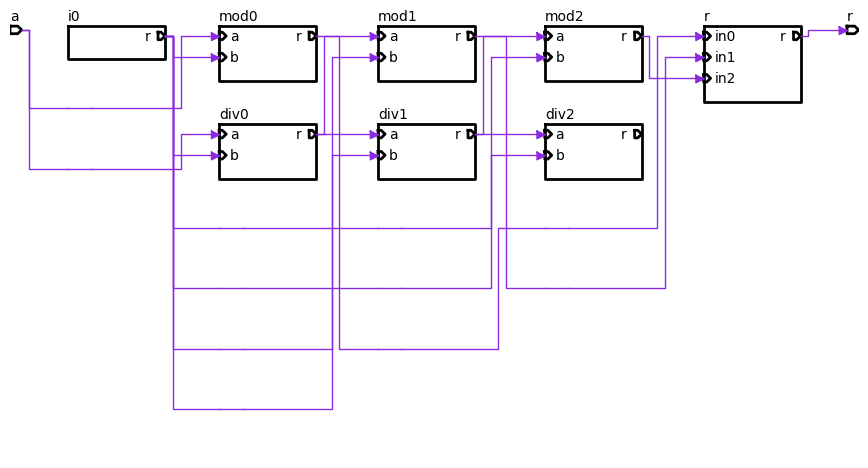

In [28]:
hw = py4hw.HWSystem()
hlp = py4hw.LogicHelper(hw)

count = hw.wire('count', 8)
bcd = hw.wire('bcd', 4*3)
py4hw.Counter(hw, 'count', inc=hlp.hw_constant(1,1), reset=hlp.hw_constant(1,0), q=count)

dut = IntToBCD(hw, 'bcd', count, bcd)

watch = [count, bcd]
watch.extend(list(dut._wires.values()))

wvf = py4hw.Waveform(hw, 'wvf', watch)
sch = py4hw.Schematic(dut)
sch.draw()

In [29]:
#for i in range(15):
#    hw.getSimulator().clk()
#    print('{:03X}'.format(bcd.get()))

### Simulation ###
Notice that the hexadecimal representation of the BCD value (bcd) is equivalent to the decimal representation of integer value (count).

In [30]:
hw.getSimulator().clk(15)
wvf.draw_wavedrom()



### Visual Feedback ###
We combine the BCD converter with several seven segments display and use the technique used in Lesson 3 to display their values.

Thus, we build a more complex simulatation environment to simultaneously test the BCD and sevent segment display.

In [31]:
class Digit7Segment(py4hw.Logic):
    def __init__(self, parent, name, v, led):
        super().__init__(parent, name)
        
        assert(led.getWidth() == 7)
        
        self.addIn('v', v)
        self.addOut('led', led)
        
        
        a_minterms = [0,2,3,5,6,7,8,9,0xA,0xC,0xE,0xF]
        b_minterms = [0,1,2,3,4,7,8,9,0xA,0xd]
        c_minterms = [0,1,3,4,5,6,7,8,9,0xA,0xb,0xd]
        d_minterms = [0,2,3,5,6,8,0xb,0xC,0xd,0xE]
        e_minterms = [0,2,6,8,0xA,0xb,0xC,0xd,0xE,0xF]
        f_minterms = [0,4,5,6,8,9,0xA,0xb,0xC,0xE,0xF]
        g_minterms = [2,3,4,5,6,8,9,0xA,0xb,0xd,0xE,0xF]
        
        
        a = self.wire('a')
        b = self.wire('b')
        c = self.wire('c')
        d = self.wire('d')
        e = self.wire('e')
        f = self.wire('f')
        g = self.wire('g')
        
        na = self.wire('na')
        nb = self.wire('nb')
        nc = self.wire('nc')
        nd = self.wire('nd')
        ne = self.wire('ne')
        nf = self.wire('nf')
        ng = self.wire('ng')
        
        py4hw.ConcatenateLSBF(self, 'led', [a,b,c,d,e,f,g], led)
        
        py4hw.SumOfMinterms(self, 'a', v, a_minterms, na)
        py4hw.SumOfMinterms(self, 'b', v, b_minterms, nb)
        py4hw.SumOfMinterms(self, 'c', v, c_minterms, nc)
        py4hw.SumOfMinterms(self, 'd', v, d_minterms, nd)
        py4hw.SumOfMinterms(self, 'e', v, e_minterms, ne)
        py4hw.SumOfMinterms(self, 'f', v, f_minterms, nf)
        py4hw.SumOfMinterms(self, 'g', v, g_minterms, ng)
        
        py4hw.Not(self, 'na', na, a)
        py4hw.Not(self, 'nb', nb, b)
        py4hw.Not(self, 'nc', nc, c)
        py4hw.Not(self, 'nd', nd, d)
        py4hw.Not(self, 'ne', ne, e)
        py4hw.Not(self, 'nf', nf, f)
        py4hw.Not(self, 'ng', ng, g)

Number of BCD digits: 3


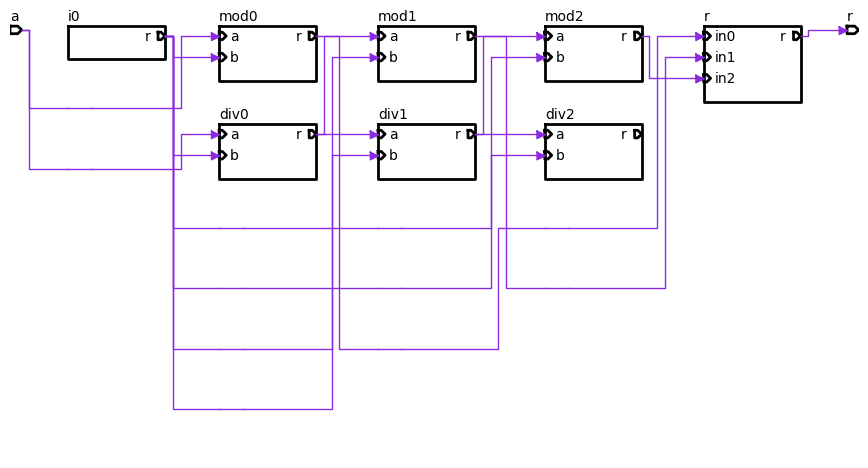

In [32]:
hw = py4hw.HWSystem()
hlp = py4hw.LogicHelper(hw)

count = hw.wire('count', 8)
bcd = hw.wire('bcd', 4*3)
py4hw.Counter(hw, 'count', inc=hlp.hw_constant(1,1), reset=hlp.hw_constant(1,0), q=count)

dut = IntToBCD(hw, 'bcd', count, bcd)
leds = []

for i in range(3):
    rng = hlp.hw_range(bcd, 4*(i+1)-1, 4*i)
    led = hw.wire('led{}'.format(i),7)
    Digit7Segment(hw, 'sev{}'.format(i), rng, led)
    leds.append(led)

wvf = py4hw.Waveform(hw, 'wvf', list(dut._wires.values()))
sch = py4hw.Schematic(dut)
sch.draw()

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def drawSevenSegments(i, v):
    plt.subplot(1,16,i+1)

    sp = 0.5
    ll = 5
    hx = np.array([0, sp, ll-sp, ll, ll-sp, sp])
    hy = np.array([0, sp, sp, 0, -sp, -sp])
    vx = np.array([0, sp, sp, 0, -sp, -sp])
    vy = np.array([0, sp, ll-sp, ll, ll-sp, sp])
    led_x=[None]*7
    led_y=[None]*7

    led_x[0] , led_y[0] = hx , hy + 2*ll     # LED a
    led_x[1] , led_y[1] = vx + ll, vy + ll     # LED b
    led_x[2] , led_y[2] = vx + ll, vy      # LED c
    led_x[3] , led_y[3] = hx , hy     # LED d
    led_x[4] , led_y[4] = vx , vy      # LED e
    led_x[5] , led_y[5] = vx , vy + ll     # LED f
    led_x[6] , led_y[6] = hx , hy + ll     # LED g
    
    vi = v.get()
    for i in range(7):
        if (not(vi & 1)):
            plt.fill(led_x[i], led_y[i], edgecolor='black', facecolor='red')
        vi = vi >> 1
    
    plt.xlim(-sp,ll+sp)
    plt.ylim(-sp, 2*ll+sp)
    plt.axis('off')

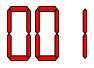

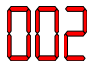

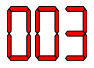

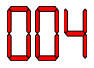

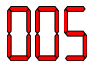

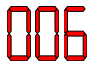

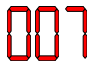

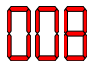

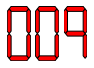

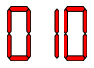

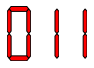

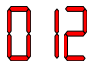

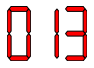

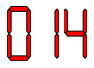

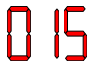

In [34]:
for i in range(15):
    plt.figure(figsize=(8,1))

    hw.getSimulator().clk()

    for i in range(3):
        drawSevenSegments(i, leds[2-i])
    plt.show()